# RNA Velocity and Metastability

One biologically-challenged assumption about application of traditional RNA velcoity:

The scale of RNA splicing/unsplicing dynamics is within hours, while in many scRNA-seq datasets, the underlying time scale of cell development is within days.

**Intuitions:** In real data, the U-S phase plane is well-clustered. However, current RNA velocity models fit all data together and only allow for one unique steady state

<img src="https://scvelo.readthedocs.io/_images/DynamicalModeling_20_0.png" />

**Speculation:** Each meta-stable state has its own equilibrium dynamics, and the time scale to reach local equilibrium is fast (within hours). The development within days/weeks are the transtion among meta-stable states.

## Simulation Data: Toggle Switch

Two genes inhibiting each other -- two steady states

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
def neg_hill(x, x0, n):
    '''
    positive Hill function
    '''
    return 1/( 1 + (x/x0)**n )


def time_course(T, dt, Ux0, Uy0, Sx0, Sy0, S0X, S0Y, n, g, kx=1, ky=1, sigma=0.002):
    '''
    time course starting from given initial conditions
    T, dt: time interval and timestep
    Ux0, Sx0, Uy0, Sy0: initial conditions
    S0X, S0Y, n, gm, kx, ky: controllable parameters of hill function
    sigma: the white noise amplitude
    returns full vectorts of time course
    '''
    npoints = int(T/dt)
    Ux, Uy, Sx, Sy = np.zeros(npoints+1),np.zeros(npoints+1),np.zeros(npoints+1),np.zeros(npoints+1)
    Ux[0], Uy[0], Sx[0], Sy[0] = Ux0, Uy0, Sx0, Sy0
    gaussian_noise = sigma*np.random.normal(loc = 0., scale = np.sqrt(dt), size=(npoints,4))
    for i in range(npoints):
        Ux[i+1] = np.maximum(Ux[i] + dt*( kx*neg_hill(Sy[i], S0Y, n) - Ux[i] )+ np.sqrt(Ux[i])*gaussian_noise[i,0],0)
        Uy[i+1] = np.maximum(Uy[i] + dt*( ky*neg_hill(Sx[i], S0X, n) - Uy[i] )+ np.sqrt(Uy[i])*gaussian_noise[i,1],0)
        Sx[i+1] = np.maximum(Sx[i] + dt*( Ux[i] - g*Sx[i] ) + np.sqrt(Sx[i])*gaussian_noise[i,2],0)
        Sy[i+1] = np.maximum(Sy[i] + dt*( Uy[i] - g*Sy[i] ) + np.sqrt(Sy[i])*gaussian_noise[i,3],0)
    return Ux, Uy, Sx, Sy

def generate_data(n_traj, x0, noise_scale_initial = 0.1,noise_scale_traj = 1e-3, T_pert = 10, dt_pert = 0.1, n = 2, g = 0.1, kx = 1, ky = 1, S0X = 1., S0Y = 1.):
  '''
  generate data from n_traj trajectories
  '''
  N = int(T_pert/dt_pert)+1
  U_data = np.zeros((n_traj*N,2))
  S_data = np.zeros((n_traj*N,2))
  for i in range(n_traj):
    # pick a small, Gaussian displacement around the fixed point
    [UX0, UY0, SX0, SY0] = x0 + noise_scale_initial*np.random.normal(loc = 0., scale = 1, size=4)*x0
    Ux_fit, Uy_fit, Sx_fit, Sy_fit = time_course(T_pert , dt_pert, UX0, UY0, SX0, SY0, S0X, S0Y, n, g, kx = kx, ky = ky, sigma =noise_scale_traj)
    ind_sample = list(range(i*N,(i+1)*N))
    U_data[ind_sample,0] = Ux_fit
    U_data[ind_sample,1] = Uy_fit
    S_data[ind_sample,0] = Sx_fit
    S_data[ind_sample,1] = Sy_fit
  return U_data,S_data

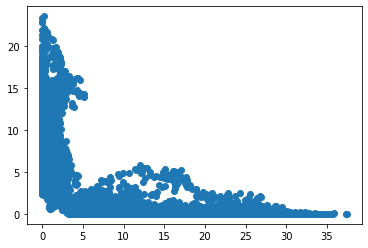

In [3]:
S0X, S0Y = 1., 1
n = 2
g = 0.1
kx = 2
ky = 1

T, dt = 200., 0.1

x01 = np.array([1,0,10,0])
x02 = np.array([0,1,0,10])
noise_scale_init = 1e-1
noise_scale_traj = 6e-1
U_data_1, S_data_1 = generate_data(n_traj = 5,T_pert = 100,x0=x01,noise_scale_initial = noise_scale_init,noise_scale_traj = noise_scale_traj, kx = kx, ky = ky, g=g)
U_data_2, S_data_2 = generate_data(n_traj = 5,T_pert = 100,x0=x02,noise_scale_initial = noise_scale_init,noise_scale_traj = noise_scale_traj, kx = kx, ky = ky, g=g)
U_data = np.concatenate((U_data_1,U_data_2))
S_data = np.concatenate((S_data_1,S_data_2))
plt.scatter(S_data[:,0],S_data[:,1])


In [4]:
import scanpy as sc
import scvelo as scv
import anndata
import pandas as pd

In [5]:
X_df = pd.DataFrame(S_data, columns = ["gene_A","gene_B"])
X_df

gene_A     gene_B
0      10.978738   0.000000
1      11.583890   0.000000
2      11.725379   0.000082
3      12.061873   0.001027
4      12.334953   0.000000
...          ...        ...
10005   0.740491  12.596205
10006   0.718070  12.869117
10007   0.999182  12.815824
10008   0.975858  12.770738
10009   0.969770  11.805122

[10010 rows x 2 columns]

## Standard scVelo Analysis

In [6]:
adata = anndata.AnnData(X = X_df)
adata.layers['spliced'] =S_data
adata.layers['unspliced']=U_data
adata.obsm['coord'] = S_data

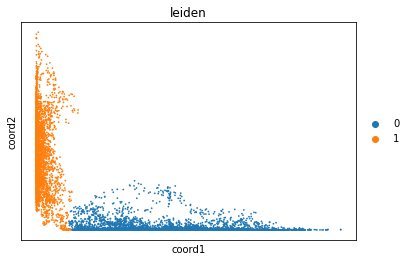

In [7]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.leiden(adata, resolution = 0.002)
sc.pl.embedding(adata, basis = 'coord',color=['leiden'])

In [8]:
adata.write('data_toggle.h5ad')

In [9]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical',use_raw = True)

recovering dynamics (using 1/8 cores)
    finished (0:00:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: gene_B
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


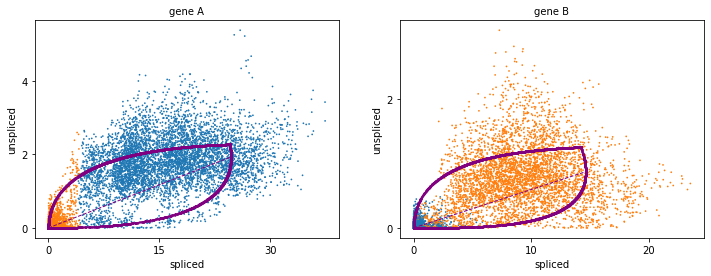

In [10]:
scv.pl.scatter(adata,basis = ['gene_A','gene_B'],color = 'leiden')

computing velocity graph (using 1/8 cores)


  0%|          | 0/10010 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Renamed 'coord' to convention 'X_coord' (adata.obsm).
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_coord', embedded velocity vectors (adata.obsm)


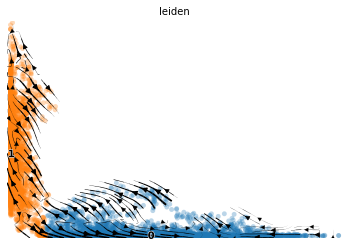

In [11]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='coord', color='leiden' )

In [13]:
adata.obsm['X_pca']=np.load('toggle_pca.npy')

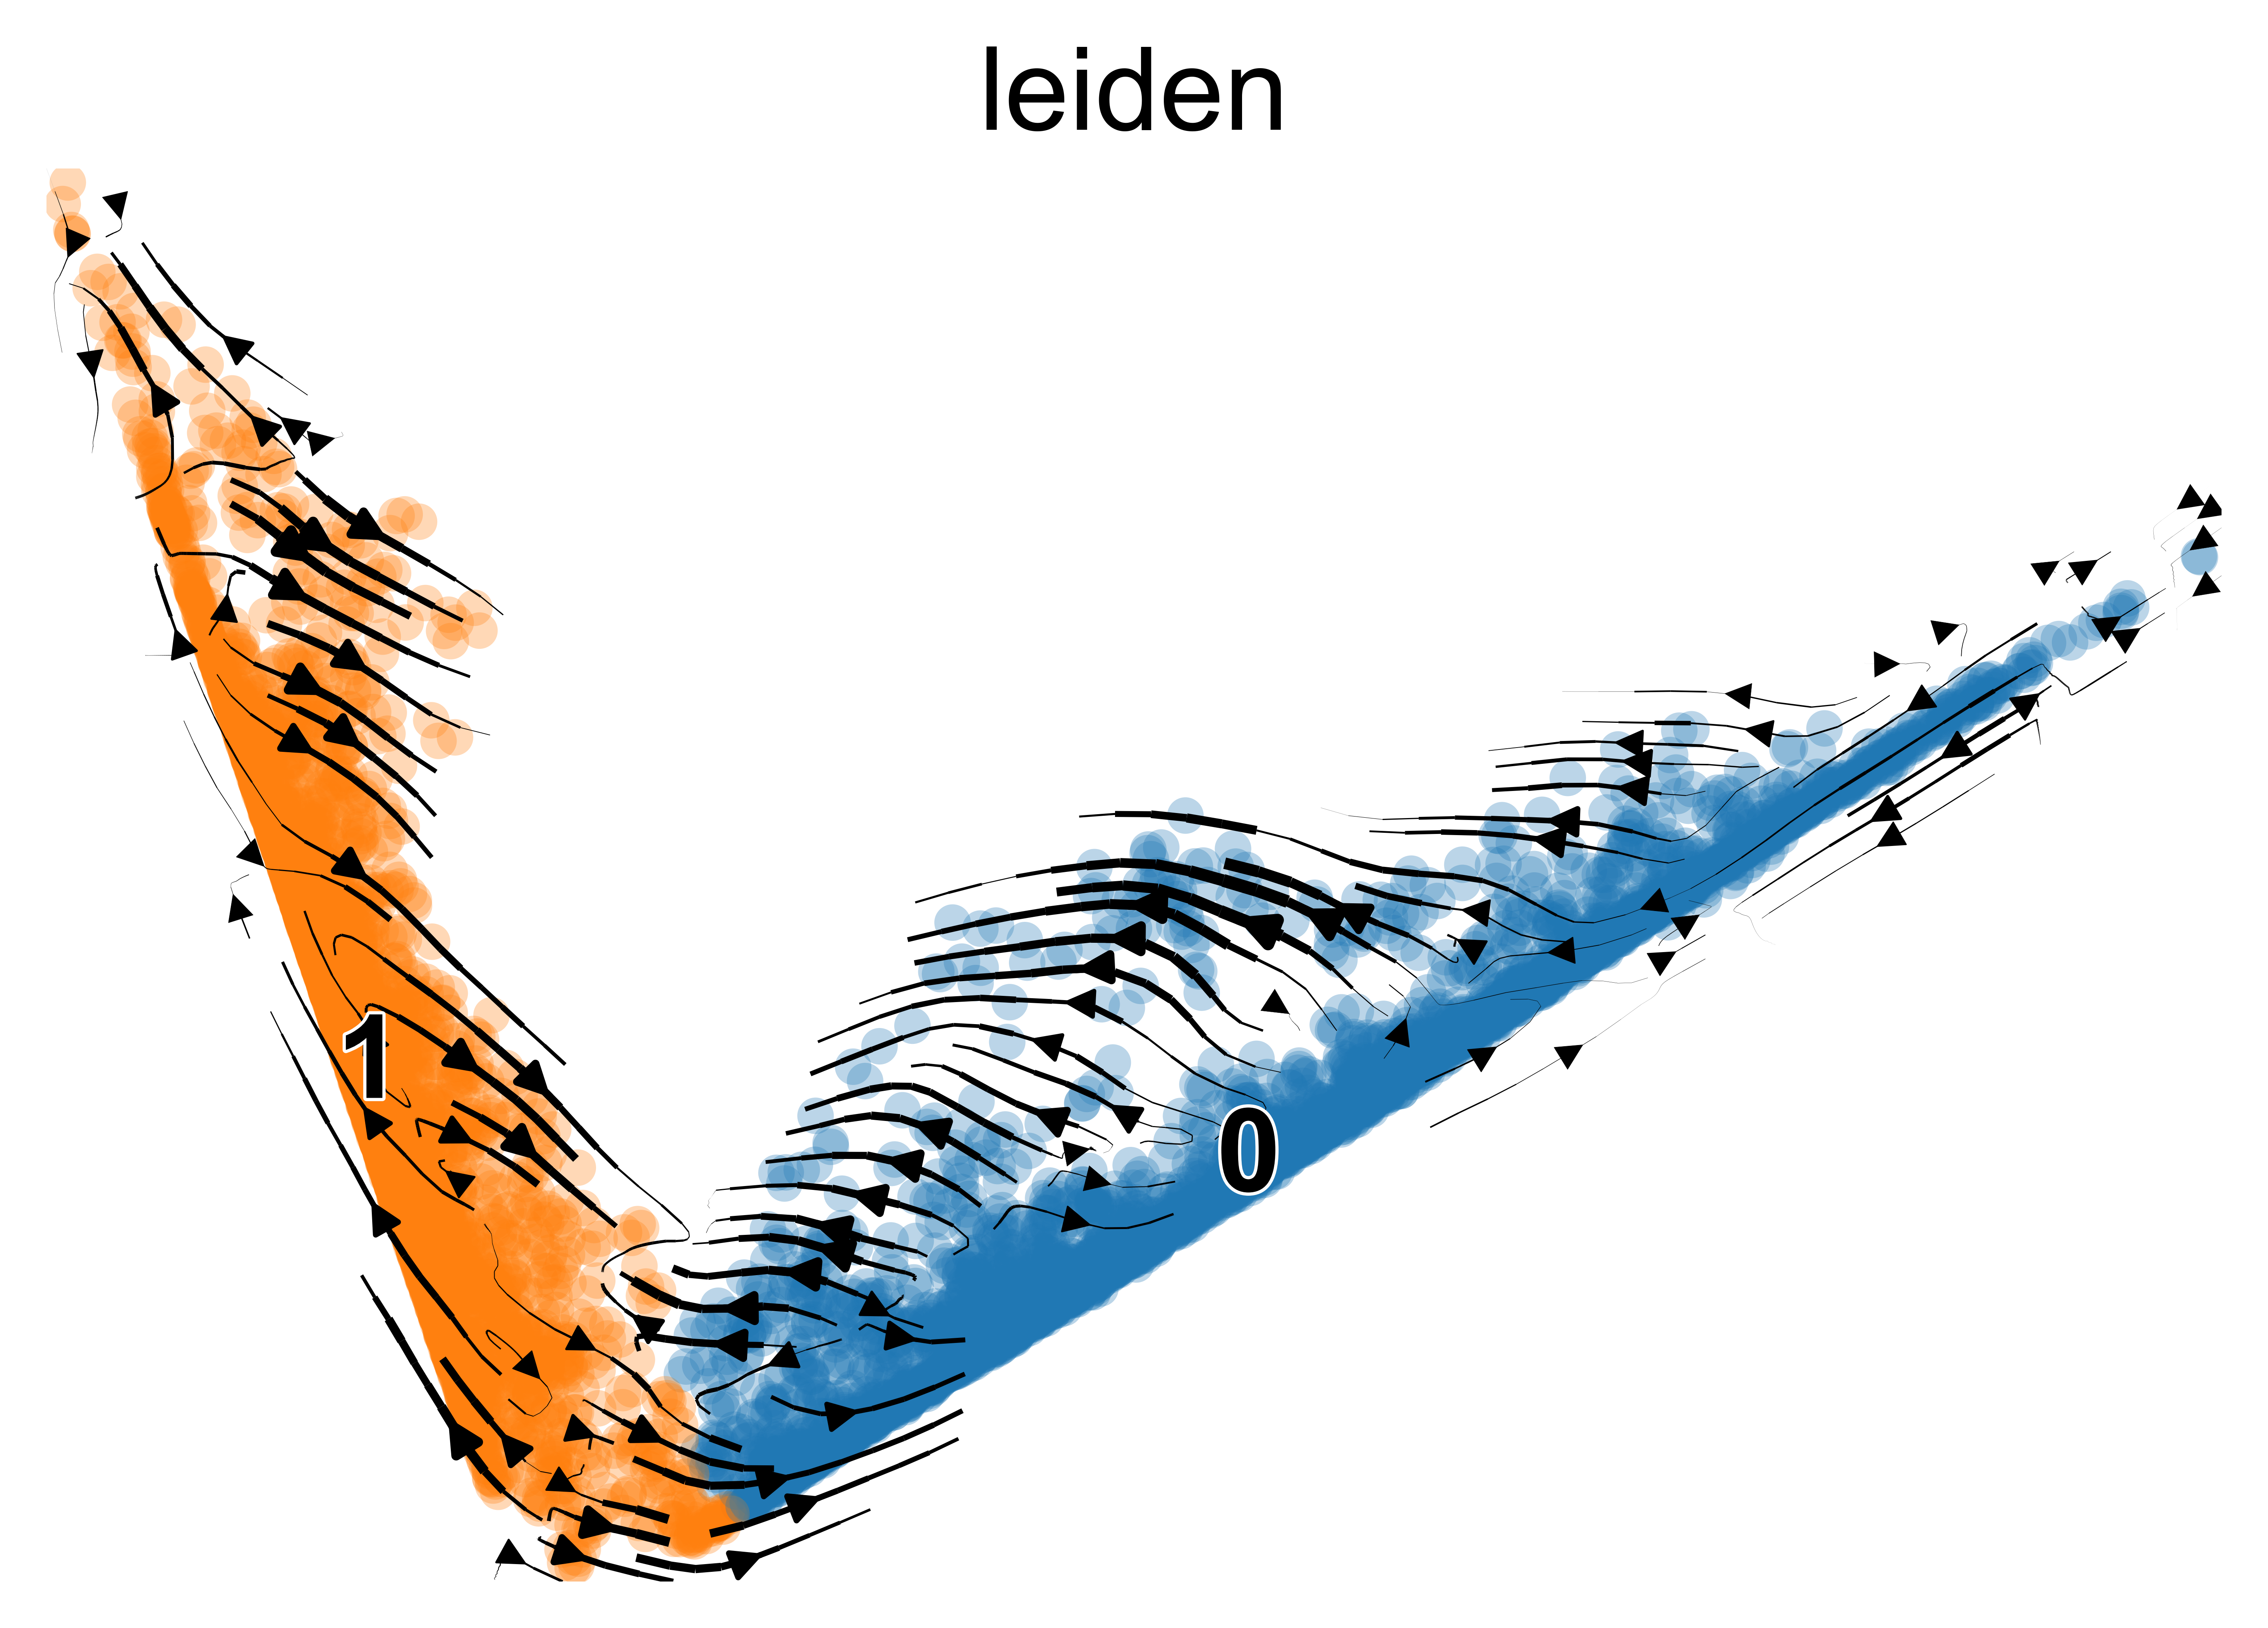

In [16]:
scv.set_figure_params(dpi =600,fontsize = 18)
scv.pl.velocity_embedding_stream(adata, basis='pca', color='leiden' )

## Another Direction: Quantifying Meta-stability from RNA Velocity

Recall the original RNA velocity model
$$\begin{align}
\frac{du_{i}}{dt} = \alpha_{i}(t)-\beta_{i} u_{i},\\
\frac{ds_{i}}{dt} = \beta_{i} u_{i}-\gamma_{i} s_{i}.
\end{align}
$$

While the more realistic model should be
$$\begin{align}
\frac{du_{i}}{dt} = f_{i}(s)-\beta_{i} u_{i},\\
\frac{ds_{i}}{dt} = \beta_{i} u_{i}-\gamma_{i} s_{i}.
\end{align}
$$
where $f_{i}(s)$ is the nonlinear function representing the effect of transcription factors

Near the steady-state, we analyze the Jacobian for linear stability analysis $$f(s)=\alpha_{i0}+\sum_{k=1}^{G}\alpha_{ik} s_{k}$$

With the estimated Jacobian, we can determine the stability of each meta-stable state